In [1]:
# defining globals
job_info_file_partial_path = 'plugin=job_table/metric=job_info_marconi100/a_0_filter123_singlenode.csv'
total_power_file_partial_path = 'plugin=ipmi_pub/metric=total_power/a_0_filter123_singlenode.csv'
column_dtypes = {'resv_name': object, 'wait4switch': object}

### Checking that start time and end time difference results in runtime for all rows in all datasets

In [2]:
import os
import pandas as pd

# Specify the root directory where your HPC job log dataset is located
root_directory = '../data'

# Iterate through each month folder
for month_folder in os.listdir(root_directory):
    month_path = os.path.join(root_directory, month_folder)

    if os.path.isdir(month_path):
        # Construct the file path based on the pattern
        file_path = os.path.join(month_path, job_info_file_partial_path)

        if os.path.exists(file_path):
            
            df = pd.read_csv(file_path, dtype=column_dtypes)
                        
            # Filter rows where start_time + runtime is not equal to end_time
            invalid_rows = df[~((pd.to_datetime(df['start_time']) + pd.to_timedelta(df['run_time'], unit='s')) == pd.to_datetime(df['end_time']))]

            # Print the invalid rows
            if not invalid_rows.empty:
                print(f'Invalid rows in {month_folder}:')
                print(invalid_rows)
                print('\n---\n')
            else:
                print("All rows have consistent start time, end time and runtime values.")

All rows have consistent start time, end time and runtime values.
All rows have consistent start time, end time and runtime values.
All rows have consistent start time, end time and runtime values.
All rows have consistent start time, end time and runtime values.


/tmp/ipykernel_221273/3273200332.py:17: DtypeWarning: Columns (88) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path, dtype=column_dtypes)


All rows have consistent start time, end time and runtime values.
All rows have consistent start time, end time and runtime values.
All rows have consistent start time, end time and runtime values.
All rows have consistent start time, end time and runtime values.
All rows have consistent start time, end time and runtime values.


### Merging IPMI dataset with job_table dataset by job ID for month 22-08

In [3]:
chunk_size = 10000  # Chunk to merge dataframes without compromising memory usage

month_path = os.path.join(root_directory, 'year_month=22-08')
job_info_file_path = os.path.join(month_path, job_info_file_partial_path)
total_power_file_path = os.path.join(month_path, total_power_file_partial_path)

job_info_chunks = pd.read_csv(job_info_file_path, dtype=column_dtypes, chunksize=chunk_size)
total_power_chunks = pd.read_csv(total_power_file_path, chunksize=chunk_size)

merged_df = pd.DataFrame()

for job_info_chunk, total_power_chunk in zip(job_info_chunks, total_power_chunks):
    merged_df_chunk = pd.merge(job_info_chunk, total_power_chunk, on='job_id', how='inner')
    merged_df = pd.concat([merged_df, merged_df_chunk], ignore_index=True)


### Visualizing the time series of power consumption for the longest running job in Marconi during 22-08

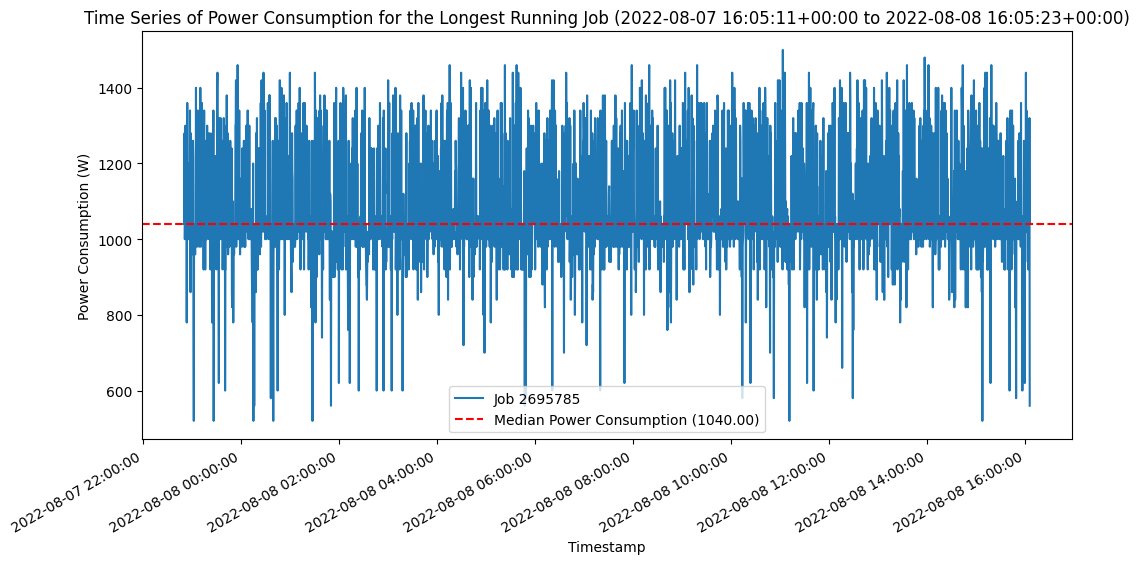

In [15]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

time_series_column = 'timestamp'
run_time_column = 'run_time'
power_consumption_column = 'value'

# Find the rows corresponding to the longest running job
longest_running_job_row = merged_df.loc[merged_df[run_time_column].idxmax()]

# Extract the information
start_time = longest_running_job_row['start_time']
end_time = longest_running_job_row['end_time']
longest_running_job_power = merged_df[merged_df['job_id'] == longest_running_job_row['job_id']][[time_series_column, power_consumption_column]]

# Calculate the median of power consumption
median_power_consumption = longest_running_job_power[power_consumption_column].median()

# Plot the time series of power consumption for the longest running job
plt.figure(figsize=(12, 6))

# Convert timestamp values to datetime objects
longest_running_job_power[time_series_column] = pd.to_datetime(longest_running_job_power[time_series_column])

plt.plot(longest_running_job_power[time_series_column], longest_running_job_power[power_consumption_column], label=f'Job {longest_running_job_row["job_id"]}')
plt.axhline(y=median_power_consumption, color='r', linestyle='--', label=f'Median Power Consumption ({median_power_consumption:.2f})')
plt.title(f'Time Series of Power Consumption for the Longest Running Job ({start_time} to {end_time})')
plt.xlabel('Timestamp')
plt.ylabel('Power Consumption (W)')

# Format the timestamp labels
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M:%S'))
plt.gcf().autofmt_xdate()  # Auto-format the x-axis date labels for better readability
plt.legend()
plt.show()


### Visualizing the time series of total power consumption in Marconi during longest job run

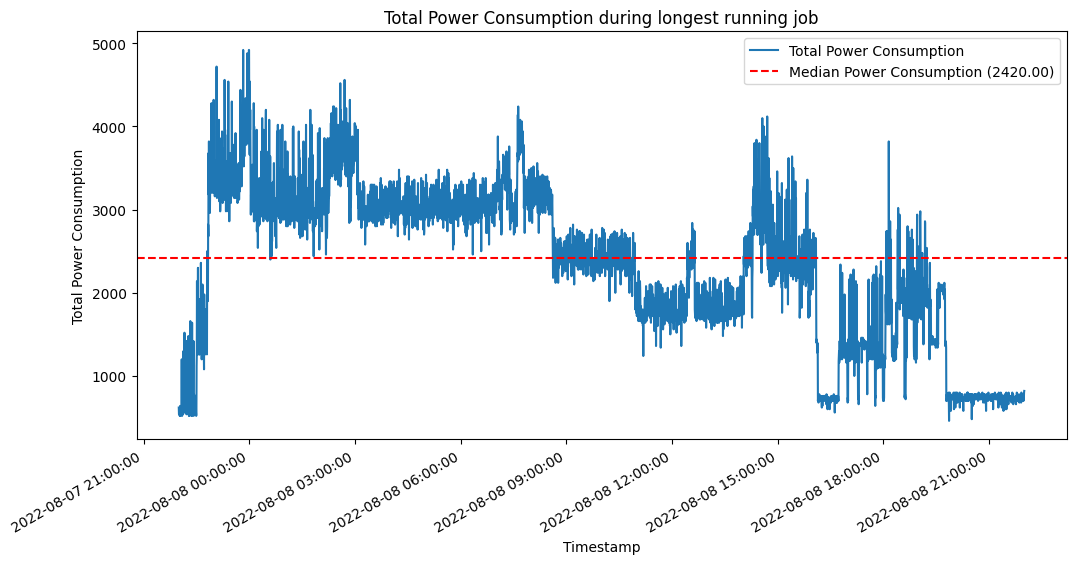

In [20]:
power_data = merged_df[[time_series_column, power_consumption_column]]

# Group by timestamp and sum the power consumption values
total_power_by_timestamp = power_data.groupby(time_series_column)[power_consumption_column].sum().reset_index()

median_total_power = total_power_by_timestamp[power_consumption_column].median()

plt.figure(figsize=(12, 6))
total_power_by_timestamp[time_series_column] = pd.to_datetime(total_power_by_timestamp[time_series_column])

plt.plot(total_power_by_timestamp[time_series_column], total_power_by_timestamp[power_consumption_column], label='Total Power Consumption')
plt.axhline(y=median_total_power, color='r', linestyle='--', label=f'Median Power Consumption ({median_total_power:.2f})')
plt.title('Total Power Consumption during longest running job')
plt.xlabel('Timestamp')
plt.ylabel('Total Power Consumption')
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M:%S'))
plt.gcf().autofmt_xdate()
plt.legend()
plt.show()
